In [62]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [63]:
import torch

# Define o device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

Usando dispositivo: cuda


In [64]:
from torchvision import datasets, transforms
import torch

data_path = './data/'

mnist = datasets.MNIST(
    data_path, train=True, download=True,
    transform=transforms.ToTensor()
)

# Empilha todas as imagens: [N, 1, 28, 28] = [batch size, canais, altura, largura] e manda para GPU
images = torch.stack([img for img, _ in mnist], dim=0).to(device)
# Calcula a média e o desvio padrão
mean = images.mean()
std = images.std()

mean, std

(tensor(0.1307, device='cuda:0'), tensor(0.3081, device='cuda:0'))

In [65]:
# Dividimos o dataset em dois conjuntos: treinamento e validação/teste
# Aplicamos normalização usando a média e desvio padrão calculados

# treino
mnist_train = datasets.MNIST(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
)

# validacao/teste
mnist_val = datasets.MNIST(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
)

In [66]:
import torch
import torch.nn as nn
import torch.optim as optim

# Cria um DataLoader:
# - o dataset é dividido em batches de 2048 imagens
# - os dados são embaralhados no início de cada época
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=2048, shuffle=True)

# Define nosso modelo com nn.Sequential
model = nn.Sequential(
    nn.Flatten(),               # achatando a imagem: [batch, 1, 28, 28] -> [batch, 784]
    nn.Linear(28*28, 512),      # camada oculta 784 -> 512
    nn.ReLU(inplace=True),
    nn.Linear(512, 256),        # camada oculta 512 -> 256
    nn.ReLU(inplace=True),
    nn.Linear(256, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 10),
                                    # 256 -> 10 classes
).to(device)

# learning rate controla o quanto os parâmetros do modelo são atualizados durante o treinamento
learning_rate = 0.05

# otimizador Stochastic Gradient Descent (SGD):
# responsável por atualizar os parâmetros usando os gradientes calculados a partir de cada batch
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# função de perda Cross-Entropy (comumente usada para classificação)
# calcula a diferença entre as probabilidades previstas pelo modelo e os rótulos verdadeiros
loss_fn = nn.CrossEntropyLoss()

# número de épocas de treino
n_epochs = 30


In [67]:
# loop de treino

for epoch in range(n_epochs):
    # itera sobre batches de imagens e rótulos
    for imgs, labels in train_loader:
        # envia os dados para o mesmo dispositivo do modelo (CPU ou GPU)
        imgs = imgs.to(device)
        labels = labels.to(device)

        # calcula a previsão do modelo
        outputs = model(imgs)

        # calcula a perda
        loss = loss_fn(outputs, labels)

        # reseta os gradientes para evitar acumulação
        optimizer.zero_grad()
        
        # calcula os gradientes da perda
        loss.backward()
        
        # atualiza os parâmetros
        optimizer.step()

    # imprime a perda ao final de cada época
    print("Época: %d, Perda: %f" % (epoch, float(loss)))

    # tempo exec 1: 10m 18.1s
    # tempo exec 2:


Época: 0, Perda: 2.179428
Época: 1, Perda: 1.531622
Época: 2, Perda: 0.757862
Época: 3, Perda: 0.612782
Época: 4, Perda: 0.500512
Época: 5, Perda: 0.414328
Época: 6, Perda: 0.361089
Época: 7, Perda: 0.271811
Época: 8, Perda: 0.296151
Época: 9, Perda: 0.286145
Época: 10, Perda: 0.322175
Época: 11, Perda: 0.279362
Época: 12, Perda: 0.309698
Época: 13, Perda: 0.251884
Época: 14, Perda: 0.240308
Época: 15, Perda: 0.226719
Época: 16, Perda: 0.194340
Época: 17, Perda: 0.179544
Época: 18, Perda: 0.174882
Época: 19, Perda: 0.213724
Época: 20, Perda: 0.176705
Época: 21, Perda: 0.161104
Época: 22, Perda: 0.214172
Época: 23, Perda: 0.160603
Época: 24, Perda: 0.140252
Época: 25, Perda: 0.138467
Época: 26, Perda: 0.118597
Época: 27, Perda: 0.186454
Época: 28, Perda: 0.178328
Época: 29, Perda: 0.146636


In [68]:
# avaliação do modelo no conjunto de treino
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print("Acurácia no treino: %.2f%%" % (100 * correct / total))


Acurácia no treino: 95.41%


In [69]:
# avaliação do modelo no conjunto de validação
val_loader = torch.utils.data.DataLoader(mnist_val, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print("Acurácia na validação: %.2f%%" % (100 * correct / total))


Acurácia na validação: 95.11%


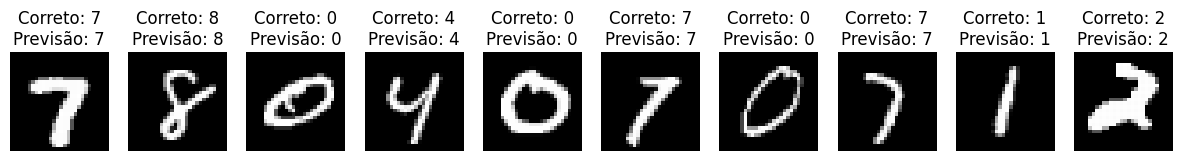

In [70]:
import random
from matplotlib import pyplot as plt

num_imgs = 10

plt.figure(figsize=(15, 3))

for i in range(num_imgs):
    # escolhe índice aleatório
    idx = random.randint(0, len(mnist_val)-1)
    
    # pega imagem e rótulo verdadeiro
    img, label = mnist_val[idx]
    
    # envia para o device e adiciona dimensão de batch
    img_tensor = img.unsqueeze(0).to(device)
    
    # passa pelo modelo
    with torch.no_grad():
        output = model(img_tensor)
        predicted = torch.argmax(output, dim=1).item()
    
    # mostra imagem
    plt.subplot(1, num_imgs, i+1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f"Correto: {label}\nPrevisão: {predicted}")
    plt.axis('off')

plt.show()
